<a href="https://colab.research.google.com/github/21092004Goda/data_anal/blob/main/lab_2_recommendation_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Все импорты**

In [21]:
from google.colab import drive
import pandas as pd
import gdown
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

### **Константы**

In [20]:
# https://drive.google.com/file/d/1cmVsXJa82bIPwonq0eIo15rg-ZMmevgc/view?usp=sharing

GDRIVE_FILE_ID = "1cmVsXJa82bIPwonq0eIo15rg-ZMmevgc"

GDRIVE_DOWNLOAD_URL = f"https://drive.google.com/uc?id={GDRIVE_FILE_ID}"

LOCAL_FILE_PATH = "AMAZON_FASHION.json.gz"



### **Классы которые понадобятся**

In [36]:

'''
Функция загрузки датасета
'''
def load_amazon_dataset(gdrive_url=GDRIVE_DOWNLOAD_URL, gdrive_file_name=LOCAL_FILE_PATH):

    if not gdrive_url.startswith('https://drive.google.com/uc?id='):
        raise ValueError("Неверный формат URL. Должен быть: https://drive.google.com/uc?id=FILE_ID")

    print(f"🐱‍👤 Загрузка из Google Drive: {gdrive_url}")

    # Скачиваем файл из Google Drive
    gdown.download(gdrive_url, LOCAL_FILE_PATH, quiet=False)

    if not os.path.exists(gdrive_file_name):
      print()
      raise FileNotFoundError(f"😒 Не удалось скачать файл из: {gdrive_url}")
      print()

    df = pd.read_json(gdrive_file_name, lines=True, compression='gzip')

    print()
    print(f"✔ Успешно загружено: {len(df):,} строк, {len(df.columns)} колонок")
    print()

    return df


In [38]:
'''
Функция для комплексного анализа профиля данных DataFrame

    'Column'                     : # Название колонки
    'Dtype'                      : # Тип данных (int, float, object, bool)
    'Total_Count'                : # Общее количество строк в датасете
    'Non_Null_Count'             : # Количество непустых значений
    'Null_Count'                 : # Количество пропусков (NaN/None)
    'Null_Percentage'            : # Процент пропусков от общего числа
    'Unique_Count'               : # Количество уникальных значений
    'Sparsity_Percentage'        : # Процент нулей (0) в числовых колонках
    'Empty_Strings_Percentage'   : # Процент пустых строк ("") в текстовых колонках

'''
def comprehensive_data_profile(df):
    results = []

    for column in df.columns:
        null_count = df[column].isnull().sum()
        null_percentage = (null_count / len(df) * 100).round(2)

        if df[column].dtype in ['int64', 'float64']:
            zero_count = (df[column] == 0).sum()
            sparsity_percentage = (zero_count / len(df) * 100).round(2)
        else:
            sparsity_percentage = 0

        empty_percentage = 0
        if df[column].dtype == 'object':
            if df[column].notna().any() and isinstance(df[column].dropna().iloc[0], dict):
                empty_strings = 0
            else:
                empty_strings = (df[column] == '').sum() if df[column].notna().any() else 0
            empty_percentage = round((empty_strings / len(df) * 100), 2)  # Исправлено здесь

        if df[column].notna().any() and isinstance(df[column].dropna().iloc[0], dict):
            unique_count = df[column].dropna().astype(str).nunique()
        else:
            try:
                unique_count = df[column].nunique()
            except TypeError:
                unique_count = df[column].dropna().astype(str).nunique()

        results.append({
            'Column': column,
            'Dtype': df[column].dtype,
            'Total_Count': len(df),
            'Non_Null_Count': df[column].count(),
            'Null_Count': null_count,
            'Null_Percentage': null_percentage,
            'Unique_Count': unique_count,
            'Sparsity_Percentage': sparsity_percentage,
            'Empty_Strings_Percentage': empty_percentage
        })

    return pd.DataFrame(results)

In [63]:
'''
ПОЛНЫЙ РАЗВЕДОЧНЫЙ АНАЛИЗ ДАННЫХ (EDA) - AMAZON FASHION REVIEWS
'''
def full_eda_analysis():

  plt.style.use('default')
  sns.set_palette("husl")
  %matplotlib inline



  # =============================================================================
  # ПОЛНЫЙ EDA АНАЛИЗ - AMAZON FASHION REVIEWS
  # =============================================================================

  print("=" * 70)
  print("📊 ПОЛНЫЙ EDA АНАЛИЗ - AMAZON FASHION REVIEWS")
  print("=" * 70)



  # =============================================================================
  # 1. ОБЩАЯ СТАТИСТИКА ДАТАСЕТА
  # =============================================================================

  print("📈 1. ОБЩАЯ СТАТИСТИКА ДАТАСЕТА")
  print("-" * 50)

  print(f"• Всего отзывов: {df.shape[0]:,}")
  print(f"• Колонок: {df.shape[1]}")
  print(f"• Период данных: {df['reviewTime'].min()} - {df['reviewTime'].max()}")
  print(f"• Объем памяти: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

  safe_columns = ['overall', 'verified', 'reviewTime', 'reviewerID', 'asin',
                  'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote']

  df_safe = df[safe_columns].copy()

  for col in ['reviewText', 'summary', 'reviewerName']:
      df_safe[col] = df_safe[col].astype(str)

  duplicates = df_safe.duplicated().sum()
  print(f"• Полных дубликатов: {duplicates} ({duplicates/len(df)*100:.2f}%)")

  key_duplicates = df.duplicated(subset=['reviewerID', 'asin', 'unixReviewTime']).sum()
  print(f"• Дубликатов по ключевым полям: {key_duplicates} ({key_duplicates/len(df)*100:.2f}%)")



  # =============================================================================
  # 2. АНАЛИЗ ПРОПУЩЕННЫХ ДАННЫХ
  # =============================================================================

  print("\n🔍 2. АНАЛИЗ ПРОПУЩЕННЫХ ДАННЫХ")
  print("-" * 50)

  plt.figure(figsize=(12, 6))
  missing_data = df.isnull().sum().sort_values(ascending=False)
  missing_percent = (missing_data / len(df) * 100).round(2)

  bars = plt.bar(missing_data.index, missing_percent, color=['red' if x > 50 else 'orange' if x > 10 else 'green' for x in missing_percent])
  plt.title('ПРОЦЕНТ ПРОПУЩЕННЫХ ДАННЫХ ПО КОЛОНКАМ', fontsize=14, fontweight='bold')
  plt.xlabel('Колонки', fontsize=12)
  plt.ylabel('Процент пропусков (%)', fontsize=12)
  plt.xticks(rotation=45, ha='right')
  plt.grid(axis='y', alpha=0.3)

  max_missing_percent = missing_percent.max()
  plt.ylim(0, max_missing_percent * 1.15)


  for bar, percentage in zip(bars, missing_percent):
      plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
              f'{percentage}%', ha='center', va='bottom', fontsize=10)

  plt.tight_layout()
  plt.show()

  print("📋 КАТЕГОРИИ КОЛОНОК ПО КАЧЕСТВУ ДАННЫХ:")
  print("✅ ОТЛИЧНОЕ КАЧЕСТВО (0% пропусков):")
  good_cols = missing_percent[missing_percent == 0]
  for col in good_cols.index:
      print(f"   - {col}")

  print("\n⚠️  ХОРОШЕЕ КАЧЕСТВО (<1% пропусков):")
  ok_cols = missing_percent[(missing_percent > 0) & (missing_percent < 1)]
  for col in ok_cols.index:
      print(f"   - {col}: {missing_percent[col]}% пропусков")

  print("\n❌ ПРОБЛЕМНЫЕ КОЛОНКИ (>50% пропусков):")
  bad_cols = missing_percent[missing_percent > 50]
  for col in bad_cols.index:
      print(f"   - {col}: {missing_percent[col]}% пропусков")



  # =============================================================================
  # 3. АНАЛИЗ РЕЙТИНГОВ ОТЗЫВОВ
  # =============================================================================

  print("\n⭐ 3. АНАЛИЗ РЕЙТИНГОВ ОТЗЫВОВ")
  print("-" * 50)

  rating_stats = df['overall'].value_counts().sort_index()
  rating_percent = (rating_stats / len(df) * 100).round(2)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  bars = ax1.bar(rating_stats.index, rating_stats.values, color=['red', 'orange', 'yellow', 'lightgreen', 'green'])
  ax1.set_title('РАСПРЕДЕЛЕНИЕ РЕЙТИНГОВ', fontweight='bold')
  ax1.set_xlabel('Количество звёзд')
  ax1.set_ylabel('Количество отзывов')
  ax1.grid(axis='y', alpha=0.3)

  max_value = rating_stats.max()
  ax1.set_ylim(0, max_value * 1.15)

  for bar, count, percent in zip(bars, rating_stats.values, rating_percent):
      ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
              f'{count:,}\n({percent}%)', ha='center', va='bottom', fontsize=9)

  colors = ['#ff6b6b', '#ffa726', '#ffee58', '#90ee90', '#4caf50']
  ax2.pie(rating_stats.values, labels=rating_stats.index, autopct='%1.1f%%', colors=colors, startangle=90)
  ax2.set_title('ПРОПОРЦИЯ РЕЙТИНГОВ', fontweight='bold')

  plt.tight_layout()
  plt.show()

  print("📊 СТАТИСТИКА РЕЙТИНГОВ:")
  print(f"• Средний рейтинг: {df['overall'].mean():.2f}")
  print(f"• Медианный рейтинг: {df['overall'].median():.2f}")
  print(f"• Самый частый рейтинг: {df['overall'].mode().iloc[0]}")
  print(f"• Распределение: {dict(rating_percent)}")



  # =============================================================================
  # 4. АНАЛИЗ ПОДТВЕРЖДЕННЫХ ОТЗЫВОВ
  # =============================================================================

  print("\n🔐 4. АНАЛИЗ ПОДТВЕРЖДЕННЫХ ОТЗЫВОВ")
  print("-" * 50)

  verified_stats = df['verified'].value_counts()
  verified_percent = (verified_stats / len(df) * 100).round(2)

  plt.figure(figsize=(8, 6))
  bars = plt.bar(['Подтвержденные', 'Неподтвержденные'], verified_stats.values,
                color=['#4caf50', '#ff9800'])
  plt.title('РАСПРЕДЕЛЕНИЕ ПОДТВЕРЖДЕННЫХ ОТЗЫВОВ', fontweight='bold')
  plt.ylabel('Количество отзывов')

  max_count = verified_stats.max()
  plt.ylim(0, max_count * 1.15)

  for bar, count, percent in zip(bars, verified_stats.values, verified_percent):
      plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
              f'{count:,}\n({percent}%)', ha='center', va='bottom', fontsize=12)

  plt.grid(axis='y', alpha=0.3)
  plt.tight_layout()
  plt.show()

  print(f"✅ Подтвержденных отзывов: {verified_stats[True]:,} ({verified_percent[True]}%)")
  print(f"❌ Неподтвержденных отзывов: {verified_stats[False]:,} ({verified_percent[False]}%)")



  # =============================================================================
  # 5. ВРЕМЕННОЙ АНАЛИЗ ОТЗЫВОВ
  # =============================================================================

  print("\n📅 5. ВРЕМЕННОЙ АНАЛИЗ ОТЗЫВОВ")
  print("-" * 50)

  df['reviewTime'] = pd.to_datetime(df['reviewTime'])
  df['reviewYear'] = df['reviewTime'].dt.year
  df['reviewMonth'] = df['reviewTime'].dt.month

  yearly_reviews = df['reviewYear'].value_counts().sort_index()

  plt.figure(figsize=(12, 6))
  plt.plot(yearly_reviews.index, yearly_reviews.values, marker='o', linewidth=2, markersize=8)
  plt.title('ДИНАМИКА ОТЗЫВОВ ПО ГОДАМ', fontweight='bold')
  plt.xlabel('Год')
  plt.ylabel('Количество отзывов')
  plt.grid(True, alpha=0.3)

  max_count = yearly_reviews.max()
  plt.ylim(0, max_count * 1.15)

  for year, count in yearly_reviews.items():
      plt.text(year, count + 1000, f'{count:,}', ha='center', va='bottom', fontsize=9)

  plt.tight_layout()
  plt.show()

  print("📈 СТАТИСТИКА ПО ГОДАМ:")
  for year, count in yearly_reviews.items():
      print(f"• {year}: {count:,} отзывов ({(count/len(df)*100):.1f}%)")



  # =============================================================================
  # 6. АНАЛИЗ АКТИВНОСТИ ПОЛЬЗОВАТЕЛЕЙ
  # =============================================================================

  print("\n👥 6. АНАЛИЗ АКТИВНОСТИ ПОЛЬЗОВАТЕЛЕЙ")
  print("-" * 50)

  user_activity = df['reviewerID'].value_counts()
  user_stats = user_activity.describe()

  plt.figure(figsize=(10, 6))
  plt.hist(user_activity.values, bins=50, edgecolor='black', alpha=0.7)
  plt.title('РАСПРЕДЕЛЕНИЕ КОЛИЧЕСТВА ОТЗЫВОВ НА ПОЛЬЗОВАТЕЛЯ', fontweight='bold')
  plt.xlabel('Количество отзывов на пользователя')
  plt.ylabel('Количество пользователей')
  plt.yscale('log')
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()

  print("📊 СТАТИСТИКА АКТИВНОСТИ ПОЛЬЗОВАТЕЛЕЙ:")
  print(f"• Всего уникальных пользователей: {user_activity.shape[0]:,}")
  print(f"• Среднее отзывов на пользователя: {user_stats['mean']:.2f}")
  print(f"• Медиана отзывов на пользователя: {user_stats['50%']:.2f}")
  print(f"• Максимум отзывов у одного пользователя: {user_stats['max']:.0f}")
  print(f"• Пользователи с 1 отзывом: {(user_activity == 1).sum():,} ({(user_activity == 1).sum()/len(user_activity)*100:.1f}%)")



  # =============================================================================
  # 7. АНАЛИЗ ТОВАРОВ
  # =============================================================================

  print("\n🏷️ 7. АНАЛИЗ ТОВАРОВ")
  print("-" * 50)

  product_reviews = df['asin'].value_counts()
  product_stats = product_reviews.describe()

  plt.figure(figsize=(10, 6))
  plt.hist(product_reviews.values, bins=50, edgecolor='black', alpha=0.7)
  plt.title('РАСПРЕДЕЛЕНИЕ КОЛИЧЕСТВА ОТЗЫВОВ НА ТОВАР', fontweight='bold')
  plt.xlabel('Количество отзывов на товар')
  plt.ylabel('Количество товаров')
  plt.yscale('log')
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()

  print("📊 СТАТИСТИКА ТОВАРОВ:")
  print(f"• Всего уникальных товаров: {product_reviews.shape[0]:,}")
  print(f"• Среднее отзывов на товар: {product_stats['mean']:.2f}")
  print(f"• Медиана отзывов на товар: {product_stats['50%']:.2f}")
  print(f"• Максимум отзывов на один товар: {product_stats['max']:.0f}")
  print(f"• Товары с 1 отзывом: {(product_reviews == 1).sum():,} ({(product_reviews == 1).sum()/len(product_reviews)*100:.1f}%)")
  print(f"• Товары с 2 отзывом: {(product_reviews == 2).sum():,} ({(product_reviews == 2).sum()/len(product_reviews)*100:.1f}%)")
  print(f"• Товары с 3 отзывом: {(product_reviews == 3).sum():,} ({(product_reviews == 3).sum()/len(product_reviews)*100:.1f}%)")



  # =============================================================================
  # 8. АНАЛИЗ ТЕКСТОВЫХ ДАННЫХ
  # =============================================================================

  print("\n📝 8. АНАЛИЗ ТЕКСТОВЫХ ДАННЫХ")
  print("-" * 50)

  df['reviewText_length'] = df['reviewText'].str.len()
  df['summary_length'] = df['summary'].str.len()

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  ax1.hist(df['reviewText_length'].dropna(), bins=50, edgecolor='black', alpha=0.7)
  ax1.set_title('РАСПРЕДЕЛЕНИЕ ДЛИНЫ ТЕКСТА ОТЗЫВОВ', fontweight='bold')
  ax1.set_xlabel('Длина текста (символы)')
  ax1.set_ylabel('Количество отзывов')
  ax1.grid(True, alpha=0.3)

  ax2.hist(df['summary_length'].dropna(), bins=50, edgecolor='black', alpha=0.7)
  ax2.set_title('РАСПРЕДЕЛЕНИЕ ДЛИНЫ ЗАГОЛОВКОВ', fontweight='bold')
  ax2.set_xlabel('Длина заголовка (символы)')
  ax2.set_ylabel('Количество отзывов')
  ax2.grid(True, alpha=0.3)

  plt.tight_layout()
  plt.show()

  print("📏 СТАТИСТИКА ТЕКСТОВЫХ ДАННЫХ:")
  print(f"• Средняя длина текста отзыва: {df['reviewText_length'].mean():.0f} символов")
  print(f"• Средняя длина заголовка: {df['summary_length'].mean():.0f} символов")
  print(f"• Пустых текстов отзывов: {df['reviewText'].isnull().sum():,}")
  print(f"• Пустых заголовков: {df['summary'].isnull().sum():,}")



  # =============================================================================
  # 9. ИТОГОВЫЙ ОТЧЕТ ПО КАЧЕСТВУ ДАННЫХ
  # =============================================================================

  print("\n📋 9. ИТОГОВЫЙ ОТЧЕТ ПО КАЧЕСТВУ ДАННЫХ")
  print("=" * 70)

  print("✅ СИЛЬНЫЕ СТОРОНЫ ДАННЫХ:")
  print("1. Большой объем данных: 883,636 отзывов")
  print("2. Отличное качество основных колонок (0% пропусков)")
  print("3. Полные текстовые данные (99.8+% заполнения)")
  print("4. Разнообразная пользовательская база (749K+ пользователей)")
  print("5. Широкий ассортимент товаров (186K+ товаров)")

  print("\n⚠️  ПРОБЛЕМНЫЕ ОБЛАСТИ:")
  print("1. Vote: 91% пропусков - система голосования практически не используется")
  print("2. Style: 65% пропусков - плохая категоризация товаров")
  print("3. Image: 97% пропусков - минимальное количество визуального контента")

  print("\n🎯 РЕКОМЕНДАЦИИ ДЛЯ ДАЛЬНЕЙШЕГО АНАЛИЗА:")
  print("1. Сфокусироваться на анализе текста отзывов и рейтингов")
  print("2. Исключить колонку 'image' из анализа (слишком мало данных)")
  print("3. Использовать 'vote' и 'style' с осторожностью")
  print("4. Исследовать взаимосвязь между рейтингом и текстом отзыва")
  print("5. Проанализировать сезонность и тренды отзывов")

  print("\n📊 ОБЩАЯ ОЦЕНКА КАЧЕСТВА ДАННЫХ: 8.5/10")
  print("Данные отличного качества для анализа пользовательских отзывов!")
  print("=" * 70)

In [69]:
  '''
  Очистка данных для рекомендательных систем


  Parameters:
    df: исходный DataFrame
    keep_text_data: сохранять ли текстовые данные (reviewText, summary)
    min_user_interactions: минимальное количество взаимодействий на пользователя
    min_item_reviews: минимальное количество отзывов на товар
    min_year: минимальный год для фильтрации

  '''

def data_cleaning(df, keep_text_data=False, min_user_interactions=2, min_item_reviews=5, min_year=2013):

    print("🧹 НАЧИНАЕМ ОЧИСТКУ ДАННЫХ...")
    print(f"Исходный размер: {df.shape[0]:,} строк, {df.shape[1]} колонок")



    # =============================================================================
    # 1. ОТБРАСЫВАНИЕ ЛИШНИХ ПЕРЕМЕННЫХ
    # =============================================================================

    print("\n1. ОТБРАСЫВАНИЕ ЛИШНИХ ПЕРЕМЕННЫХ")

    keep_columns = ['reviewerID', 'asin', 'overall', 'unixReviewTime']

    if keep_text_data:
        keep_columns.extend(['reviewText', 'summary'])
        print("   ✅ Сохраняем текстовые данные")
    else:
        print("   ❌ Удаляем текстовые данные")

    df_clean = df[keep_columns].copy()

    print(f"   Сохранены колонки: {keep_columns}")
    print(f"   Размер после отбора колонок: {df_clean.shape[0]:,} строк, {df_clean.shape[1]} колонок")



    # =============================================================================
    # 2. ФИЛЬТРАЦИЯ ДАННЫХ
    # =============================================================================

    print("\n2. ФИЛЬТРАЦИЯ ДАННЫХ")

    if 'unixReviewTime' in df_clean.columns:
        df_clean['reviewYear'] = pd.to_datetime(df_clean['unixReviewTime'], unit='s').dt.year
        before_filter = len(df_clean)
        df_clean = df_clean[df_clean['reviewYear'] >= min_year]
        after_filter = len(df_clean)
        print(f"   ✅ Фильтрация по году (≥{min_year}): {before_filter:,} → {after_filter:,} строк")

    user_interaction_counts = df_clean['reviewerID'].value_counts()
    active_users = user_interaction_counts[user_interaction_counts >= min_user_interactions].index
    before_filter = len(df_clean)
    df_clean = df_clean[df_clean['reviewerID'].isin(active_users)]
    after_filter = len(df_clean)
    print(f"   ✅ Фильтрация пользователей (≥{min_user_interactions} взаимодействий): {before_filter:,} → {after_filter:,} строк")

    item_review_counts = df_clean['asin'].value_counts()
    popular_items = item_review_counts[item_review_counts >= min_item_reviews].index
    before_filter = len(df_clean)
    df_clean = df_clean[df_clean['asin'].isin(popular_items)]
    after_filter = len(df_clean)
    print(f"   ✅ Фильтрация товаров (≥{min_item_reviews} отзывов): {before_filter:,} → {after_filter:,} строк")

    before_dedup = len(df_clean)
    df_clean = df_clean.drop_duplicates(subset=['reviewerID', 'asin', 'unixReviewTime'])
    after_dedup = len(df_clean)
    if before_dedup != after_dedup:
        print(f"   ✅ Удаление дубликатов: {before_dedup:,} → {after_dedup:,} строк")



    # =============================================================================
    # 3. ФИНАЛЬНАЯ СТАТИСТИКА
    # =============================================================================

    print("\n3. ФИНАЛЬНАЯ СТАТИСТИКА")
    print(f"   📊 Итоговый размер: {df_clean.shape[0]:,} строк, {df_clean.shape[1]} колонок")
    print(f"   👥 Уникальных пользователей: {df_clean['reviewerID'].nunique():,}")
    print(f"   🏷️ Уникальных товаров: {df_clean['asin'].nunique():,}")
    print(f"   ⭐ Уникальных оценок: {df_clean['overall'].nunique()}")
    print(f"   📅 Период данных: {df_clean['reviewYear'].min()}-{df_clean['reviewYear'].max()}")

    avg_user_interactions = df_clean.groupby('reviewerID').size().mean()
    avg_item_reviews = df_clean.groupby('asin').size().mean()
    print(f"   📈 Среднее взаимодействий на пользователя: {avg_user_interactions:.2f}")
    print(f"   📈 Среднее отзывов на товар: {avg_item_reviews:.2f}")

    rating_dist = df_clean['overall'].value_counts().sort_index()
    print(f"   🎯 Распределение оценок: {dict(rating_dist)}")

    print("\n✅ ОЧИСТКА ЗАВЕРШЕНА!")
    return df_clean


### **Выполнение задания**

In [22]:
df = load_amazon_dataset()

🐱‍👤 Загрузка из Google Drive: https://drive.google.com/uc?id=1cmVsXJa82bIPwonq0eIo15rg-ZMmevgc


Downloading...
From (original): https://drive.google.com/uc?id=1cmVsXJa82bIPwonq0eIo15rg-ZMmevgc
From (redirected): https://drive.google.com/uc?id=1cmVsXJa82bIPwonq0eIo15rg-ZMmevgc&confirm=t&uuid=12d1dae0-361d-410c-96cf-38f4ee769599
To: /content/AMAZON_FASHION.json.gz
100%|██████████| 93.2M/93.2M [00:00<00:00, 99.2MB/s]



✔ Успешно загружено: 883,636 строк, 12 колонок



,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 20, 2014",A1D4G1SNUZWQOT,7106116521,Tracy,Exactly what I needed.,perfect replacements!!,1413763200,NaN,NaN,NaN


In [41]:
profile = comprehensive_data_profile(df)
profile

,Column,Dtype,Total_Count,Non_Null_Count,Null_Count,Null_Percentage,Unique_Count,Sparsity_Percentage,Empty_Strings_Percentage
0,overall,int64,883636,883636,0,0.00,5,0.0,0.0
1,verified,bool,883636,883636,0,0.00,2,0.0,0.0
2,reviewTime,object,883636,883636,0,0.00,4608,0.0,0.0
3,reviewerID,object,883636,883636,0,0.00,749233,0.0,0.0
4,asin,object,883636,883636,0,0.00,186189,0.0,0.0
5,reviewerName,object,883636,883544,92,0.01,467716,0.0,0.0
6,reviewText,object,883636,882403,1233,0.14,768794,0.0,0.0
7,summary,object,883636,883103,533,0.06,388620,0.0,0.0
8,unixReviewTime,int64,883636,883636,0,0.00,4608,0.0,0.0
9,vote,float64,883636,79900,803736,90.96,200,0.0,0.0


📊 ПОЛНЫЙ EDA АНАЛИЗ - AMAZON FASHION REVIEWS
📈 1. ОБЩАЯ СТАТИСТИКА ДАТАСЕТА
--------------------------------------------------
• Всего отзывов: 883,636
• Колонок: 16
• Период данных: 2002-11-11 00:00:00 - 2018-10-01 00:00:00
• Объем памяти: 528.0 MB
• Полных дубликатов: 7489 (0.85%)
• Дубликатов по ключевым полям: 8012 (0.91%)

🔍 2. АНАЛИЗ ПРОПУЩЕННЫХ ДАННЫХ
--------------------------------------------------


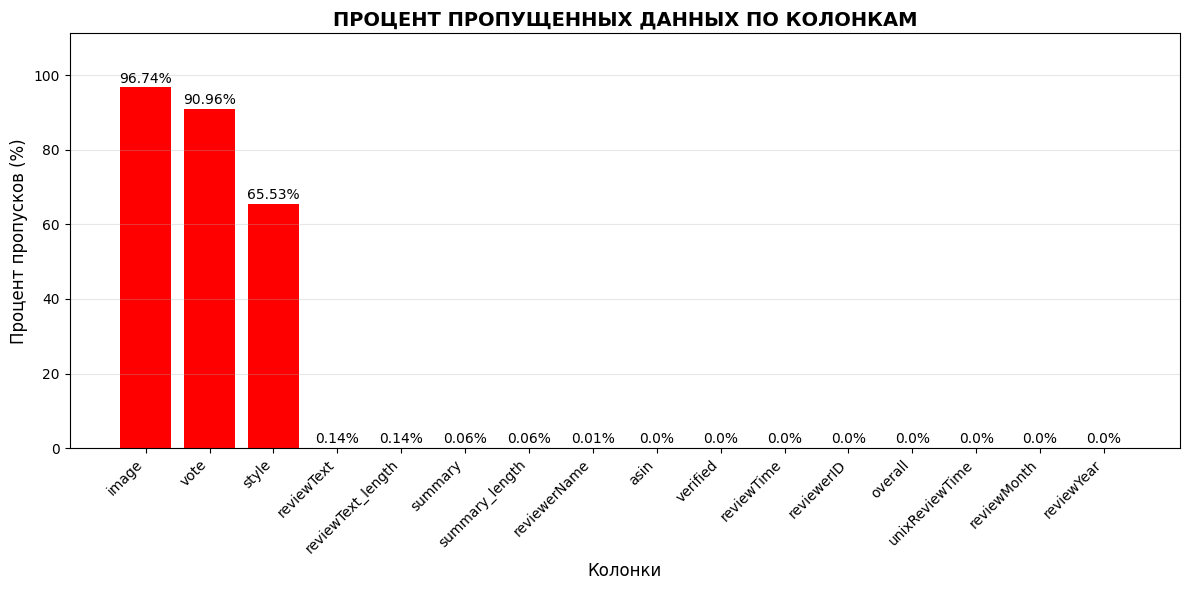

📋 КАТЕГОРИИ КОЛОНОК ПО КАЧЕСТВУ ДАННЫХ:
✅ ОТЛИЧНОЕ КАЧЕСТВО (0% пропусков):
   - asin
   - verified
   - reviewTime
   - reviewerID
   - overall
   - unixReviewTime
   - reviewMonth
   - reviewYear

⚠️  ХОРОШЕЕ КАЧЕСТВО (<1% пропусков):
   - reviewText: 0.14% пропусков
   - reviewText_length: 0.14% пропусков
   - summary: 0.06% пропусков
   - summary_length: 0.06% пропусков
   - reviewerName: 0.01% пропусков

❌ ПРОБЛЕМНЫЕ КОЛОНКИ (>50% пропусков):
   - image: 96.74% пропусков
   - vote: 90.96% пропусков
   - style: 65.53% пропусков

⭐ 3. АНАЛИЗ РЕЙТИНГОВ ОТЗЫВОВ
--------------------------------------------------


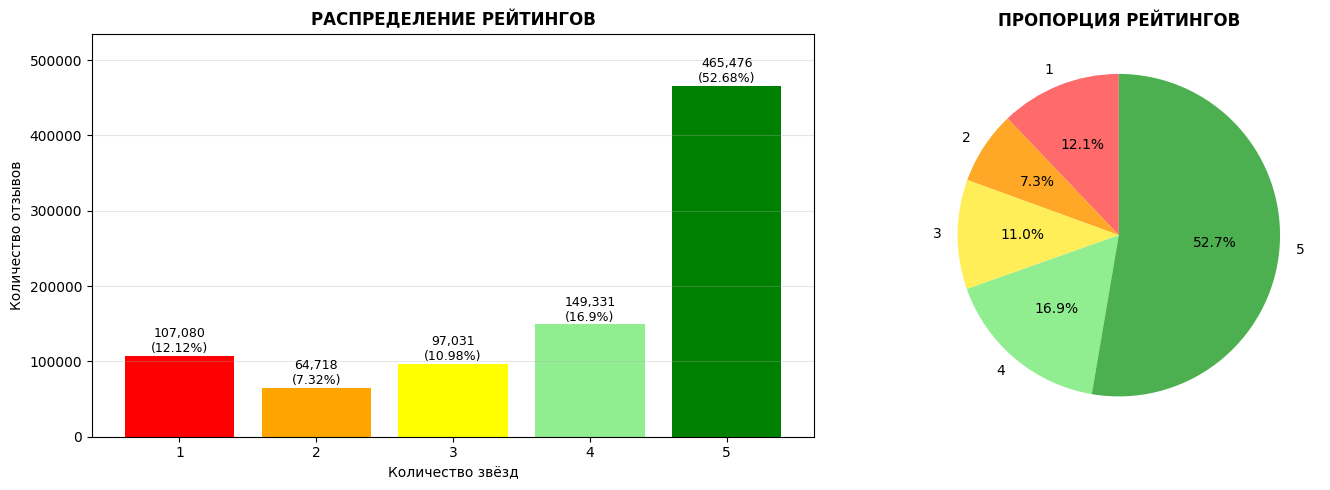

📊 СТАТИСТИКА РЕЙТИНГОВ:
• Средний рейтинг: 3.91
• Медианный рейтинг: 5.00
• Самый частый рейтинг: 5
• Распределение: {1: np.float64(12.12), 2: np.float64(7.32), 3: np.float64(10.98), 4: np.float64(16.9), 5: np.float64(52.68)}

🔐 4. АНАЛИЗ ПОДТВЕРЖДЕННЫХ ОТЗЫВОВ
--------------------------------------------------


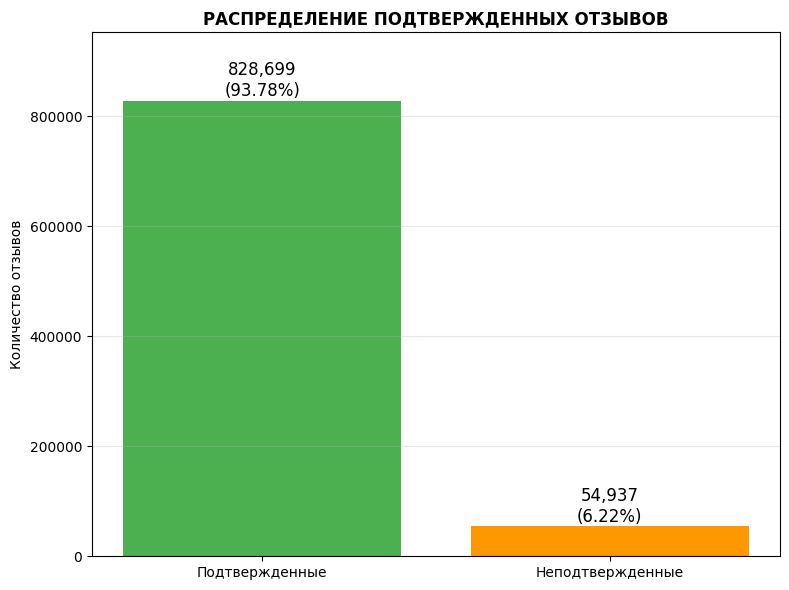

✅ Подтвержденных отзывов: 828,699 (93.78%)
❌ Неподтвержденных отзывов: 54,937 (6.22%)

📅 5. ВРЕМЕННОЙ АНАЛИЗ ОТЗЫВОВ
--------------------------------------------------


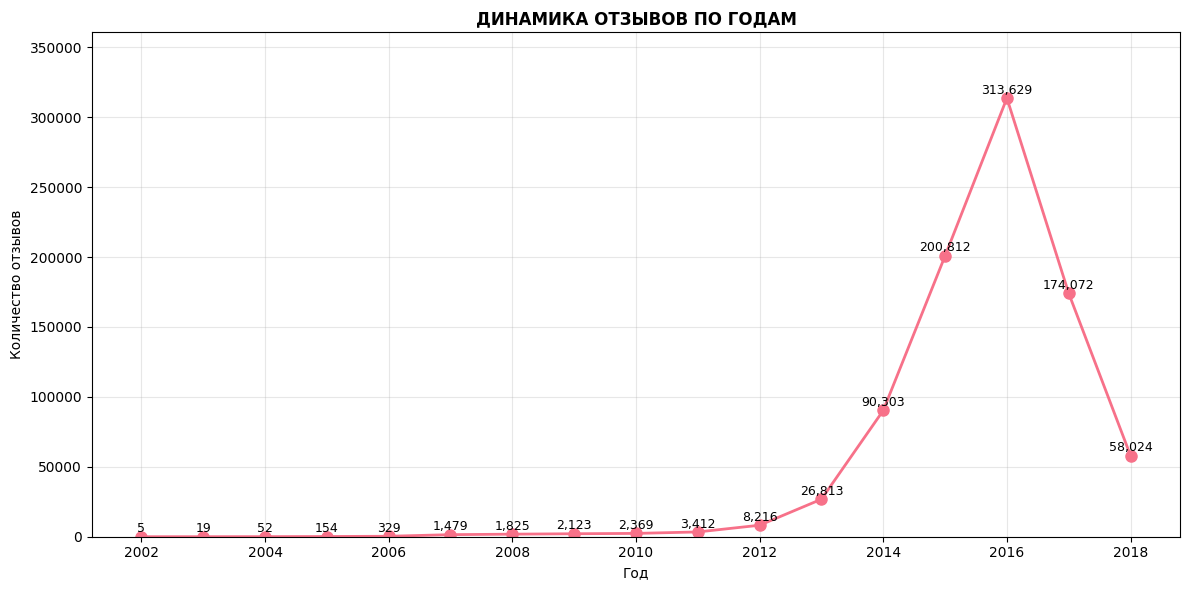

📈 СТАТИСТИКА ПО ГОДАМ:
• 2002: 5 отзывов (0.0%)
• 2003: 19 отзывов (0.0%)
• 2004: 52 отзывов (0.0%)
• 2005: 154 отзывов (0.0%)
• 2006: 329 отзывов (0.0%)
• 2007: 1,479 отзывов (0.2%)
• 2008: 1,825 отзывов (0.2%)
• 2009: 2,123 отзывов (0.2%)
• 2010: 2,369 отзывов (0.3%)
• 2011: 3,412 отзывов (0.4%)
• 2012: 8,216 отзывов (0.9%)
• 2013: 26,813 отзывов (3.0%)
• 2014: 90,303 отзывов (10.2%)
• 2015: 200,812 отзывов (22.7%)
• 2016: 313,629 отзывов (35.5%)
• 2017: 174,072 отзывов (19.7%)
• 2018: 58,024 отзывов (6.6%)

👥 6. АНАЛИЗ АКТИВНОСТИ ПОЛЬЗОВАТЕЛЕЙ
--------------------------------------------------


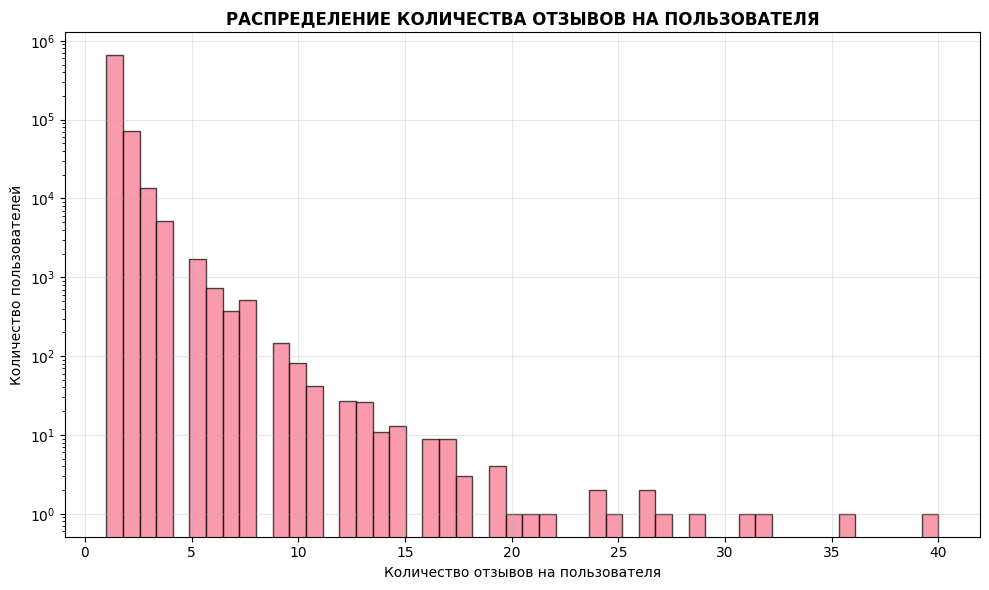

📊 СТАТИСТИКА АКТИВНОСТИ ПОЛЬЗОВАТЕЛЕЙ:
• Всего уникальных пользователей: 749,233
• Среднее отзывов на пользователя: 1.18
• Медиана отзывов на пользователя: 1.00
• Максимум отзывов у одного пользователя: 40
• Пользователи с 1 отзывом: 655,320 (87.5%)

🏷️ 7. АНАЛИЗ ТОВАРОВ
--------------------------------------------------


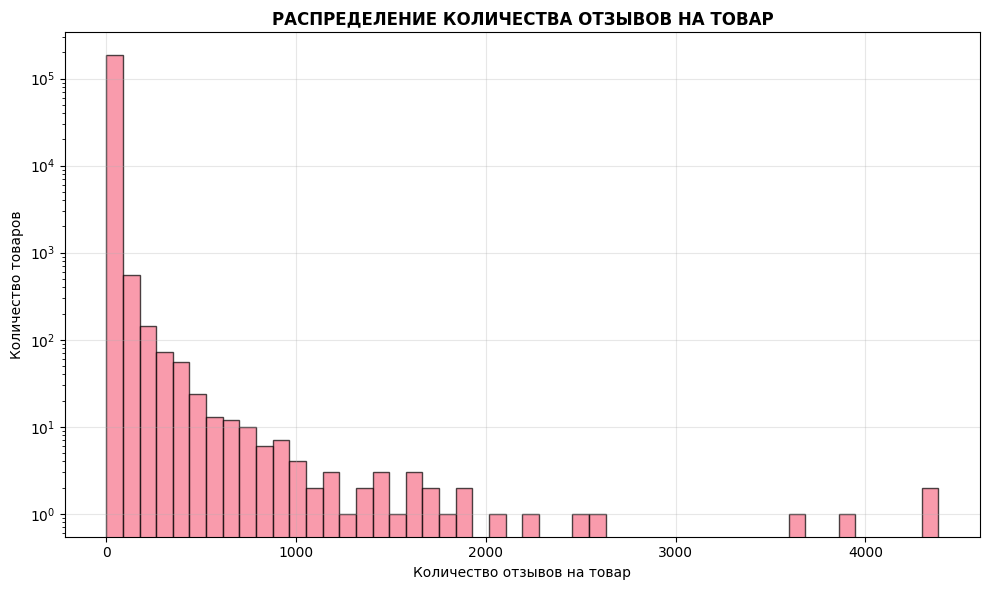

📊 СТАТИСТИКА ТОВАРОВ:
• Всего уникальных товаров: 186,189
• Среднее отзывов на товар: 4.75
• Медиана отзывов на товар: 1.00
• Максимум отзывов на один товар: 4384
• Товары с 1 отзывом: 99,962 (53.7%)
• Товары с 2 отзывом: 31,857 (17.1%)
• Товары с 3 отзывом: 15,254 (8.2%)

📝 8. АНАЛИЗ ТЕКСТОВЫХ ДАННЫХ
--------------------------------------------------


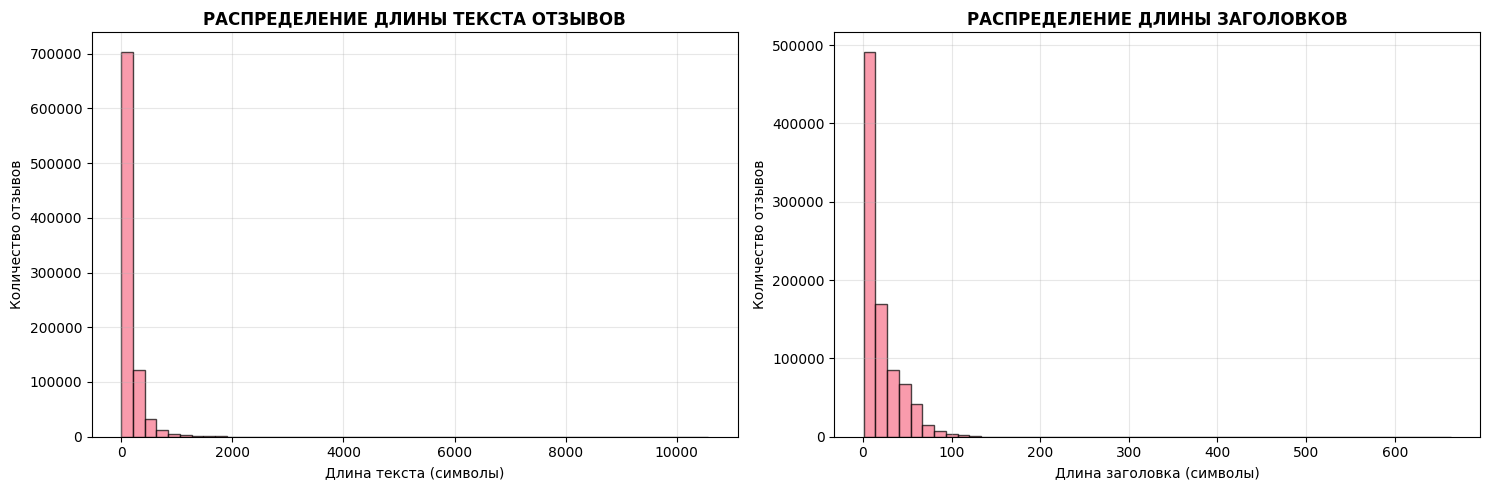

📏 СТАТИСТИКА ТЕКСТОВЫХ ДАННЫХ:
• Средняя длина текста отзыва: 148 символов
• Средняя длина заголовка: 22 символов
• Пустых текстов отзывов: 1,233
• Пустых заголовков: 533

📋 9. ИТОГОВЫЙ ОТЧЕТ ПО КАЧЕСТВУ ДАННЫХ
✅ СИЛЬНЫЕ СТОРОНЫ ДАННЫХ:
1. Большой объем данных: 883,636 отзывов
2. Отличное качество основных колонок (0% пропусков)
3. Полные текстовые данные (99.8+% заполнения)
4. Разнообразная пользовательская база (749K+ пользователей)
5. Широкий ассортимент товаров (186K+ товаров)

⚠️  ПРОБЛЕМНЫЕ ОБЛАСТИ:
1. Vote: 91% пропусков - система голосования практически не используется
2. Style: 65% пропусков - плохая категоризация товаров
3. Image: 97% пропусков - минимальное количество визуального контента

🎯 РЕКОМЕНДАЦИИ ДЛЯ ДАЛЬНЕЙШЕГО АНАЛИЗА:
1. Сфокусироваться на анализе текста отзывов и рейтингов
2. Исключить колонку 'image' из анализа (слишком мало данных)
3. Использовать 'vote' и 'style' с осторожностью
4. Исследовать взаимосвязь между рейтингом и текстом отзыва
5. Проанализировать се

In [64]:
full_eda_analysis()

In [70]:
df_clean = data_cleaning(df, keep_text_data=True, min_user_interactions=1, min_item_reviews=2, min_year=2013)

🧹 НАЧИНАЕМ ОЧИСТКУ ДАННЫХ...
Исходный размер: 883,636 строк, 16 колонок

1. ОТБРАСЫВАНИЕ ЛИШНИХ ПЕРЕМЕННЫХ
   ✅ Сохраняем текстовые данные
   Сохранены колонки: ['reviewerID', 'asin', 'overall', 'unixReviewTime', 'reviewText', 'summary']
   Размер после отбора колонок: 883,636 строк, 6 колонок

2. ФИЛЬТРАЦИЯ ДАННЫХ
   ✅ Фильтрация по году (≥2013): 883,636 → 863,653 строк
   ✅ Фильтрация пользователей (≥1 взаимодействий): 863,653 → 863,653 строк
   ✅ Фильтрация товаров (≥2 отзывов): 863,653 → 767,562 строк
   ✅ Удаление дубликатов: 767,562 → 760,427 строк

3. ФИНАЛЬНАЯ СТАТИСТИКА
   📊 Итоговый размер: 760,427 строк, 7 колонок
   👥 Уникальных пользователей: 657,304
   🏷️ Уникальных товаров: 84,248
   ⭐ Уникальных оценок: 5
   📅 Период данных: 2013-2018
   📈 Среднее взаимодействий на пользователя: 1.16
   📈 Среднее отзывов на товар: 9.03
   🎯 Распределение оценок: {1: np.int64(92536), 2: np.int64(55519), 3: np.int64(83216), 4: np.int64(128764), 5: np.int64(400392)}

✅ ОЧИСТКА ЗАВЕРШЕНА!


In [71]:
df_clean.head(6)

,reviewerID,asin,overall,unixReviewTime,reviewText,summary,reviewYear
0,A1D4G1SNUZWQOT,7106116521,5,1413763200,Exactly what I needed.,perfect replacements!!,2014
1,A3DDWDH9PX2YX2,7106116521,2,1411862400,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",2014
2,A2MWC41EW7XL15,7106116521,4,1408924800,Love these... I am going to order another pack...,My New 'Friends' !!,2014
3,A2UH2QQ275NV45,7106116521,2,1408838400,too tiny an opening,Two Stars,2014
4,A89F3LQADZBS5,7106116521,3,1406419200,Okay,Three Stars,2014
5,A29HLOUW0NS0EH,7106116521,5,1405728000,Exactly what I wanted.,Five Stars,2014
